In [1]:
library(tidyverse)
library(ggplot2)
library(gridExtra)
library(fgsea)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [28]:
hgnc2ensembl <- function (df) {

    hgncgenes <- df %>% pull(hgnc_symbol) %>% unique()
    hgncgenes <- hgncgenes[which(!is.na(hgncgenes))]
    merge_col <- "hgnc_symbol"

    if(!(require(EnsDb.Hsapiens.v79))) {
      if (!requireNamespace("BiocManager", quietly = TRUE))
        install.packages("BiocManager")
      BiocManager::install("EnsDb.Hsapiens.v79")
    }
    library(EnsDb.Hsapiens.v79)

    gene_info <- ensembldb::select(EnsDb.Hsapiens.v79,
                                   keys = hgncgenes,
                                   keytype = "SYMBOL",
                                   columns = c("SYMBOL", "GENEID", "ENTREZID")) %>%
        as_tibble() %>%
        dplyr::rename(ensembl_gene_id = GENEID,
                      hgnc_symbol = SYMBOL,
                      entrez_id = ENTREZID) %>%
        dplyr::filter(grepl('ENSG', ensembl_gene_id)) # filter out alternate gene symbols

    print("Adding ensembl_gene_ids...")
    df <- merge(df, gene_info, by = merge_col, all.x = TRUE)
    return(df)

}

prepABCforGSEA <- function(df) {
    # converts TargetGenes (hgnc) to unique ensIDs

    # some hgcn's have multiple ensg's but usually lower ID number is in ENSG
    # keep just one
    df <- df %>%
        dplyr::rename(hgnc_symbol = TargetGene) %>%
        hgnc2ensembl(.) %>%
        group_by(hgnc_symbol,name) %>%
        arrange(ensembl_gene_id, entrez_id, .by_group=TRUE) %>%
        dplyr::slice(1) %>%
        ungroup() %>%
        arrange(p)

    return(df)

}

In [118]:
plotTopPways <- function(res, topN=5, cwidths=c(5, 3, 0.6, .8, .8), debug=FALSE) {
    
    # don't include pathway category in every plotted pathway name
    res$res_df$pathway <- gsub('(HALLMARK_|GOBP_)', '', res$res_df$pathway)
    names(res$pwaylist) <- gsub('(HALLMARK_|GOBP_)', '', names(res$pwaylist))
    
    # add newline if more than 45 characters and 5 words in pathway
    pwyc <- res$res_df$pathway
    pwyl <- names(res$pwaylist)
    llc <- pwyc[nchar(pwyc) > 45]
    lll <- pwyl[nchar(pwyl) > 45]
    res$res_df$pathway[nchar(pwyc) > 45] <- gsub("((?:[^_]*_){4}[^_]*)_", "\\1_\n", llc)
    names(res$pwaylist)[nchar(pwyl) > 45] <- gsub("((?:[^_]*_){4}[^_]*)_", "\\1_\n", lll)

    topPathwaysUp <- res$res_df[ES > 0][head(order(pval), n=topN), pathway]
    topPathwaysDown <- res$res_df[ES < 0][head(order(pval), n=topN), pathway]
    topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
    
    if (debug) return(list(topPathways, res$pwaylist[topPathways]))
    
    p1 <- plotGseaTable(res$pwaylist[topPathways],
                        res$ranklist,
                        res$res_df,
                        gseaParam=0.5,
                        colwidths=cwidths,
                        render=FALSE)

    return(p1)

}

In [115]:
xp <- c('HOMOPHILIC_CELL_ADHESION_VIA_PLASMA_MEMBRANE_ADHESION_MOLECULES',
        'GLYCEROL_ETHER_METABOLIC_PROCESS',
        'sp_sp_sp_sp_sp_sp_sp_sp')
longlabs <- xp[nchar(xp) > 45]
xp[nchar(xp) > 45] <- gsub("([^_]*_[^_]*_[^_]*_[^_]*_[^_]*)_", "\\1_\n", longlabs)
xp

[1] "HOMOPHILIC_CELL_ADHESION_VIA_PLASMA_\nMEMBRANE_ADHESION_MOLECULES"
[2] "GLYCEROL_ETHER_METABOLIC_PROCESS"                                 
[3] "sp_sp_sp_sp_sp_sp_sp_sp"

In [111]:
xp <- c('HOMOPHILIC_CELL_ADHESION_VIA_PLASMA_MEMBRANE_ADHESION_MOLECULES',
        'GLYCEROL_ETHER_METABOLIC_PROCESS',
        'sp_sp_sp_sp_sp_sp_sp_sp')

nchar(xp)

[1] 63 32 23

In [110]:
xp <- c('HOMOPHILIC_CELL_ADHESION_VIA_PLASMA_MEMBRANE_ADHESION_MOLECULES',
        'GLYCEROL_ETHER_METABOLIC_PROCESS',
        'sp_sp_sp_sp_sp_sp_sp_sp')

xp <- gsub("((?:[^_]*_){4}[^_]*)_", "\\1_\n", xp)
xp

[1] "HOMOPHILIC_CELL_ADHESION_VIA_PLASMA_\nMEMBRANE_ADHESION_MOLECULES"
[2] "GLYCEROL_ETHER_METABOLIC_PROCESS"                                 
[3] "sp_sp_sp_sp_sp_\nsp_sp_sp"

In [138]:
gridPlotTopPways <- function(res1, res2, score_column='ABC.Score', debug=FALSE) {

    p1 <- plotTopPways(res1, cwidths=c(2.5, 3, 0.6, .8, .8))
    
    if (debug) return(p1)
    
    p2 <- plotTopPways(res2, cwidths=c(6.8, 3, 0.6, .8, .8))

    options(repr.plot.width = 21, repr.plot.height = 5, repr.plot.res = 200)

    g1 <- gridExtra::grid.arrange(
          p2,
          p1,
          nrow = 1,
          widths = c(2.7,2.3),
          top = grid::textGrob(
               score_column,
               gp = grid::gpar(fontsize = 26),
               x = unit(0.54, "npc")
          ),
          padding = unit(2, "line")
        )

    return(g1)

}

run_gsea <- function(df,
                     genesets=NULL,
                     gene_col='entrez_id',
                     gsea_col='gsea_stat',
                     unique_enh=FALSE,
                     return_plot_data=FALSE,
                     debug=FALSE) {

    if (!(gene_col %in% colnames(df))) {
        df <- prepABCforGSEA(df)
    }

    df <- df %>%
        dplyr::rename(gene := {{gene_col}},
                      gsea_var := {{gsea_col}}) %>%
        dplyr::filter(!is.na(gene)) %>%
        group_by(gene) %>%
        arrange(desc(abs(gsea_var)), .by_group=TRUE) %>%
        dplyr::slice(1) %>%
        ungroup() %>%
        arrange(gsea_var)

    if (unique_enh) {
        df <- df %>%
            group_by(name) %>%
            # choose gene semi-arbitrarily for now (lower ens number)
            arrange(gene) %>%
            dplyr::slice(1) %>%
            ungroup()
    }

    if (debug) return(df)

    rankstat <- setNames(df$gsea_var, df$gene)

    if (!require(fgsea)) {
        if (!require("BiocManager", quietly = TRUE))
            install.packages("BiocManager")

        BiocManager::install("fgsea")

    }
    library(fgsea)
    if (is.null(genesets)) {
        print("Using example pathways")
        data(examplePathways)
        msigdbr_list <- examplePathways
    } else {
        if (gene_col=='entrez_id') {
            gscol <- 'entrez_gene'
        } else if (gene_col=='ensembl_gene_id') {
            gscol <- 'ensembl_gene'
        } else if (gene_col %in% c('hgnc_symbol','TargetGene')) {
            gscol <- 'gene_symbol'
        } else {
            stop(paste('Gene col',gene_col,'not supported!'))
        }
        msigdbr_list <- split(x = genesets[[gscol]], f = genesets$gs_name)
    }

    res <- fgsea(pathways = msigdbr_list,
                  stats    = rankstat,
                   minSize = 15, maxSize = 500) %>%
        arrange(pval)

    if (return_plot_data) {
        # pwaylist and ranklist used as input to plotEnrichment
        # for characteristic GSEA single pathway enrichment plots
        return(list(res_df=res, pwaylist=msigdbr_list, ranklist=rankstat))
    }

    return(res)

}

aggregate_gsea <- function(d, allgenesets=NULL, remove_antisense=FALSE, debug=FALSE) {

    if (is.null(allgenesets)) {

        if (!(require(msigdbr))) install.packages("msigdbr")
        library(msigdbr)

        allgenesets <- msigdbr("Homo sapiens")

    }

    adg <- d %>%
        group_by(score_type, TargetGene) %>%
        arrange(p, desc(abs(gsea_stat)), .by_group=TRUE) %>%
        dplyr::slice(1) %>%
        ungroup()

    if (remove_antisense) {

        # remove antisense genes whos' sense genes have the same value

        print("Removing redundant antisense genes...")
        adg <- adg %>%
            separate(TargetGene,
                     c('senseGene','antisenseNum'),
                     sep='-AS',
                     remove=FALSE,
                     convert=TRUE,
                     fill='right') %>%
            group_by(score_type, gsea_stat) %>%
            mutate(N_AS_pairs = length(senseGene) - n_distinct(senseGene)) %>%
            ungroup() %>%
            dplyr::filter(!(!is.na(antisenseNum) & N_AS_pairs > 0)) %>%
            dplyr::select(-all_of(c('senseGene','antisenseNum')))

    }

    sts <- adg %>% pull(score_type) %>% unique()

    ares_df <- tibble()

    for (i in seq_along(sts)) {

        st <- sts[i]

        print(paste0('Processing diff-', st))

        dg <- adg %>% dplyr::filter(score_type==st)

        print('    Hallmark enrichments...')
        hreslist <- run_gsea(dg,
                            genesets=allgenesets %>%
                                dplyr::filter(gs_cat=='H'),
                            gene_col='TargetGene',
                            gsea_col='gsea_stat',
                            unique_enh=FALSE,
                            return_plot_data=TRUE,
                            debug=FALSE)

        print('    GO:BP enrichments...')
        bpreslist <- run_gsea(dg,
                            genesets=allgenesets %>%
                                dplyr::filter(gs_subcat=='GO:BP'),
                            gene_col='TargetGene',
                            gsea_col='gsea_stat',
                            unique_enh=FALSE,
                            return_plot_data=TRUE,
                            debug=FALSE)

        cres_df <- rbind(
            hreslist$res_df %>%
                mutate(gs_category='Hallmark'),
            bpreslist$res_df %>%
                mutate(gs_category='GO:BP')
        ) %>%
            mutate(score_type=st)

        ares_df <- rbind(ares_df, cres_df)

        g1 <- gridPlotTopPways(hreslist, bpreslist, score_column=st, debug=FALSE)
        
        if (debug) return(g1)
        
        if (i==1) {
            agg_g <- g1
        } else {
            agg_g <- rbind(agg_g, g1)
        }
#         i = i + 1

    }

    return(list(res_df=ares_df, plot_obj=agg_g))

}

In [30]:
outdir <- '/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/manuscript/figs/noCEU/supp'
d_all_fname <- '/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/180922outputNoCEU/diffABC/HiChIP/aggregate/allZerosFilt.meanQN.14.AFR_EUR.diff.allComponents.txt.gz'

In [5]:
d_all <- read_tsv(d_all_fname)
head(d_all)

Rows: 209816 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (9): seqnames, strand, class, TargetGene, name, group1, group2, score_t...
dbl (22): start, end, width, TargetGeneTSS, TargetGeneExpression, distance, ...
lgl  (3): isSelfPromoter, TargetGeneIsExpressed, selection_candidate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


seqnames,start,end,width,strand,class,TargetGene,TargetGeneTSS,TargetGeneExpression,distance,⋯,score_type,RSNUM,max_abs_ihs,rank2_abs_ihs,rank2_percentile,selection_candidate,ihs_pos,FST,fst_percentile,FST_pos
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
chr19,58838084,58838864,781,*,promoter,A1BG,58864865,1.819925,26391.0,⋯,ABC,rs60121895,1.553,1.381,0.8370710,FALSE,58838509,0.0759106,0.8702811,58838509
chr19,58873687,58874546,860,*,promoter,A1BG,58864865,1.819925,9251.5,⋯,ABC,rs145521824,1.399,0.940,0.6576563,FALSE,58873694,0.1019730,0.9011235,58874262
chr19,58838084,58838864,781,*,promoter,A1BG-AS1,58863335,NA,24861.0,⋯,ABC,rs60121895,1.553,1.381,0.8370710,FALSE,58838509,0.0759106,0.8702811,58838509
chr19,58873687,58874546,860,*,promoter,A1BG-AS1,58863335,NA,10781.5,⋯,ABC,rs145521824,1.399,0.940,0.6576563,FALSE,58873694,0.1019730,0.9011235,58874262
chr12,9255999,9256500,502,*,genic,A2M,9268825,0.095923,12575.5,⋯,ABC,rs226391,1.123,1.113,0.7392141,FALSE,9256354,0.1982870,0.9564241,9256255
chr12,9270663,9271300,638,*,intergenic,A2M,9268825,0.095923,2156.5,⋯,ABC,rs76971454,1.748,1.057,0.7144360,FALSE,9270897,0.0731984,0.8657801,9270989


In [9]:
d_all <- d_all %>% 
    mutate(score_type = case_when(score_type=='ABC' ~ 'ABC',
                                  score_type=='atac' ~ 'ATAC',
                                  score_type=='chip' ~ 'ChIP',
                                  score_type=='hic' ~ 'HiC'))
head(d_all)

seqnames,start,end,width,strand,class,TargetGene,TargetGeneTSS,TargetGeneExpression,distance,⋯,score_type,RSNUM,max_abs_ihs,rank2_abs_ihs,rank2_percentile,selection_candidate,ihs_pos,FST,fst_percentile,FST_pos
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
chr19,58838084,58838864,781,*,promoter,A1BG,58864865,1.819925,26391.0,⋯,ABC,rs60121895,1.553,1.381,0.8370710,FALSE,58838509,0.0759106,0.8702811,58838509
chr19,58873687,58874546,860,*,promoter,A1BG,58864865,1.819925,9251.5,⋯,ABC,rs145521824,1.399,0.940,0.6576563,FALSE,58873694,0.1019730,0.9011235,58874262
chr19,58838084,58838864,781,*,promoter,A1BG-AS1,58863335,NA,24861.0,⋯,ABC,rs60121895,1.553,1.381,0.8370710,FALSE,58838509,0.0759106,0.8702811,58838509
chr19,58873687,58874546,860,*,promoter,A1BG-AS1,58863335,NA,10781.5,⋯,ABC,rs145521824,1.399,0.940,0.6576563,FALSE,58873694,0.1019730,0.9011235,58874262
chr12,9255999,9256500,502,*,genic,A2M,9268825,0.095923,12575.5,⋯,ABC,rs226391,1.123,1.113,0.7392141,FALSE,9256354,0.1982870,0.9564241,9256255
chr12,9270663,9271300,638,*,intergenic,A2M,9268825,0.095923,2156.5,⋯,ABC,rs76971454,1.748,1.057,0.7144360,FALSE,9270897,0.0731984,0.8657801,9270989


[1] "Removing redundant antisense genes..."
[1] "Processing diff-ABC"
[1] "    Hallmark enrichments..."


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (12.13% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "    GO:BP enrichments..."


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (12.13% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "Processing diff-ATAC"
[1] "    Hallmark enrichments..."


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (21.22% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "    GO:BP enrichments..."


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (21.22% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "Processing diff-ChIP"
[1] "    Hallmark enrichments..."


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (17.95% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "    GO:BP enrichments..."


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (17.95% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


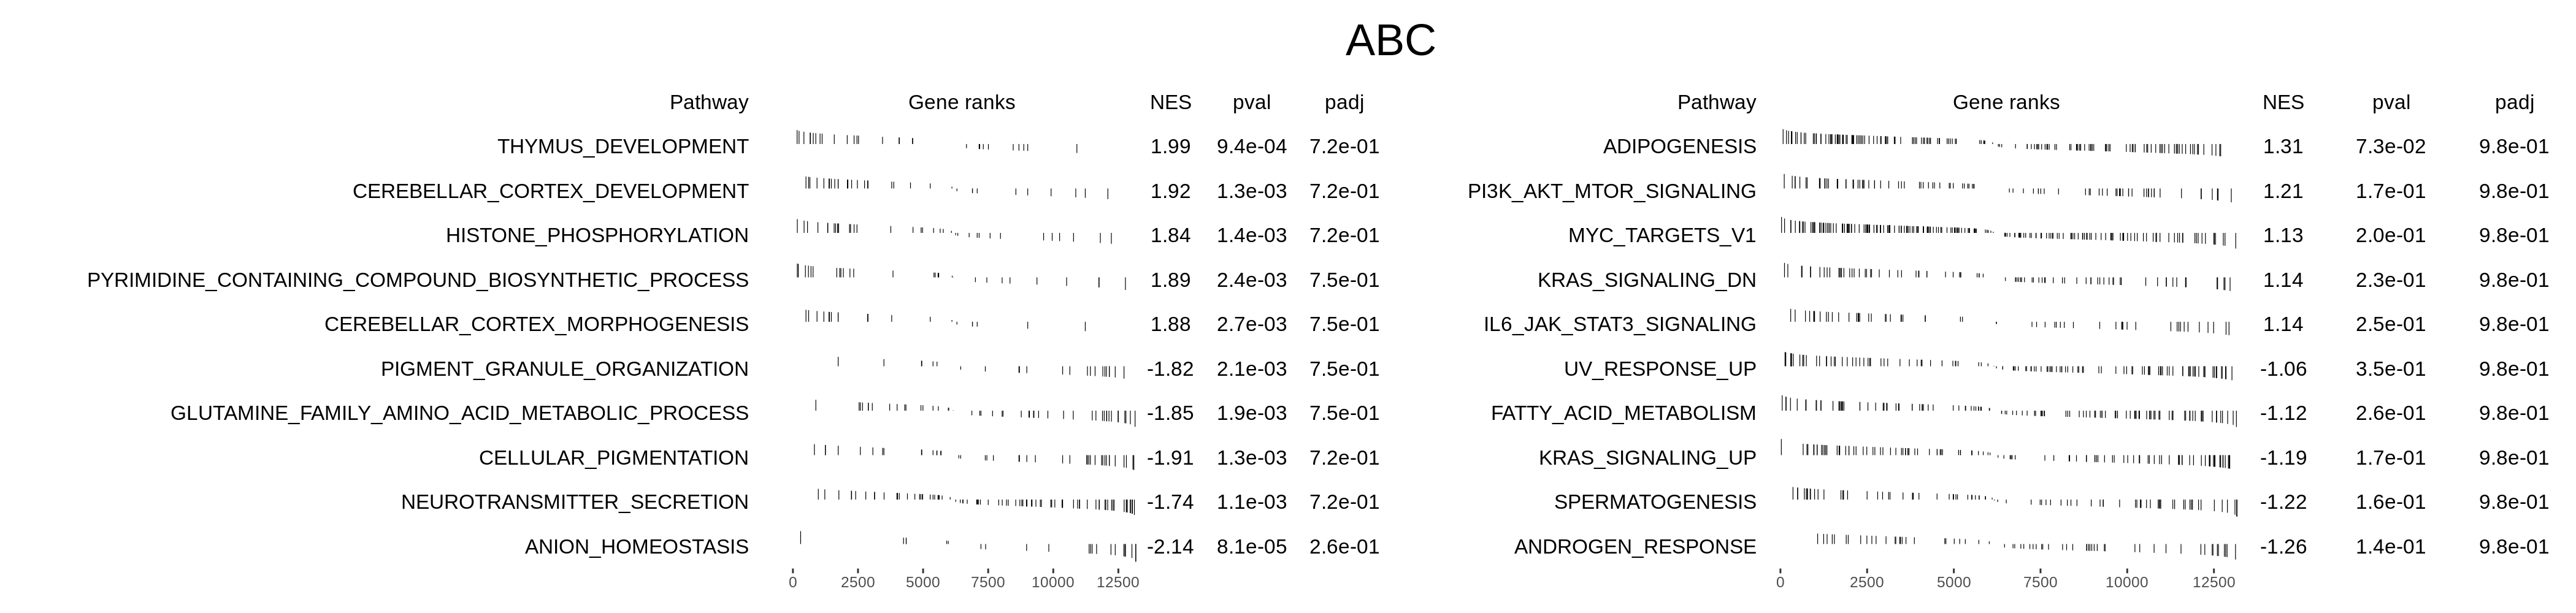

[1] "Processing diff-HiC"
[1] "    Hallmark enrichments..."


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (12.12% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "    GO:BP enrichments..."


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (12.12% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


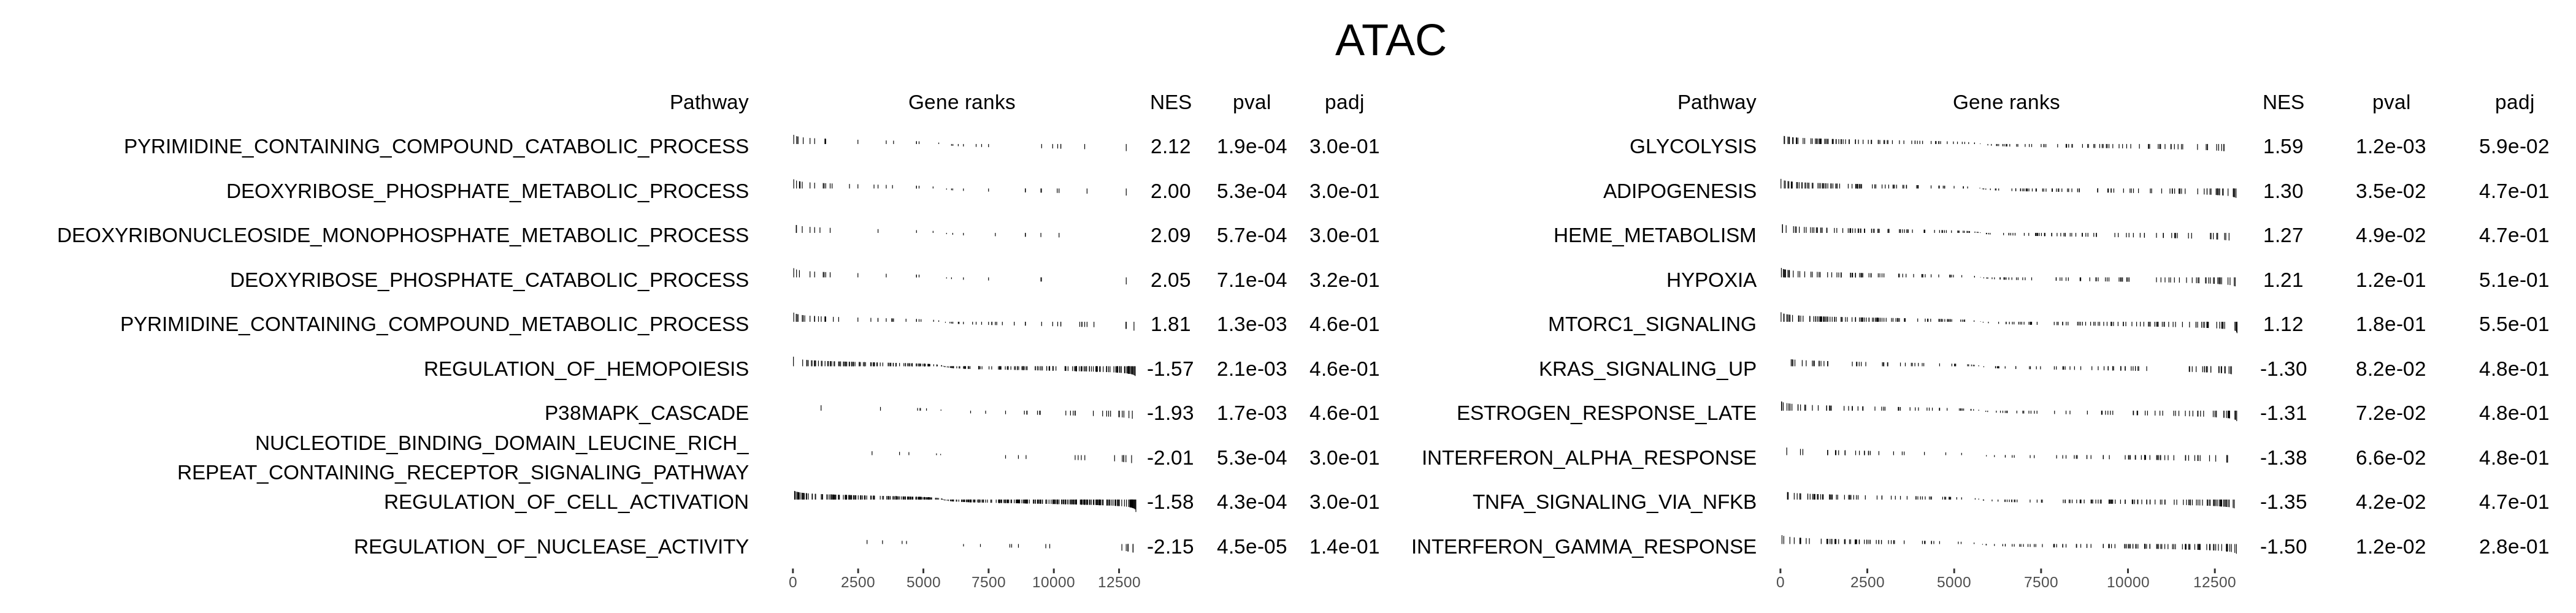

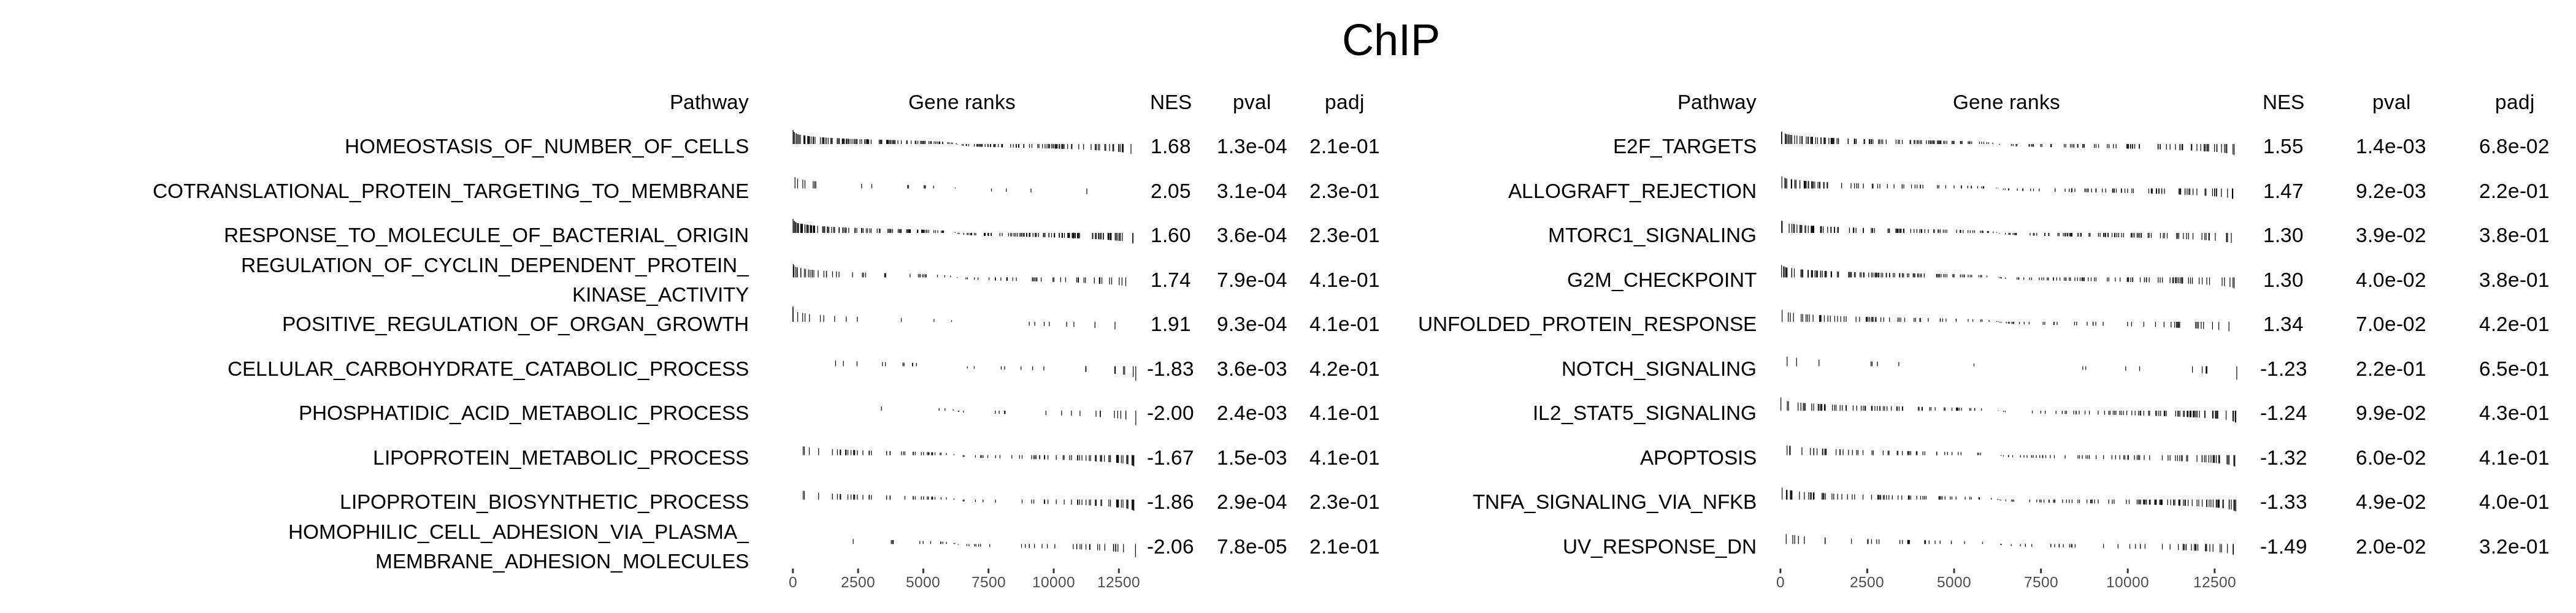

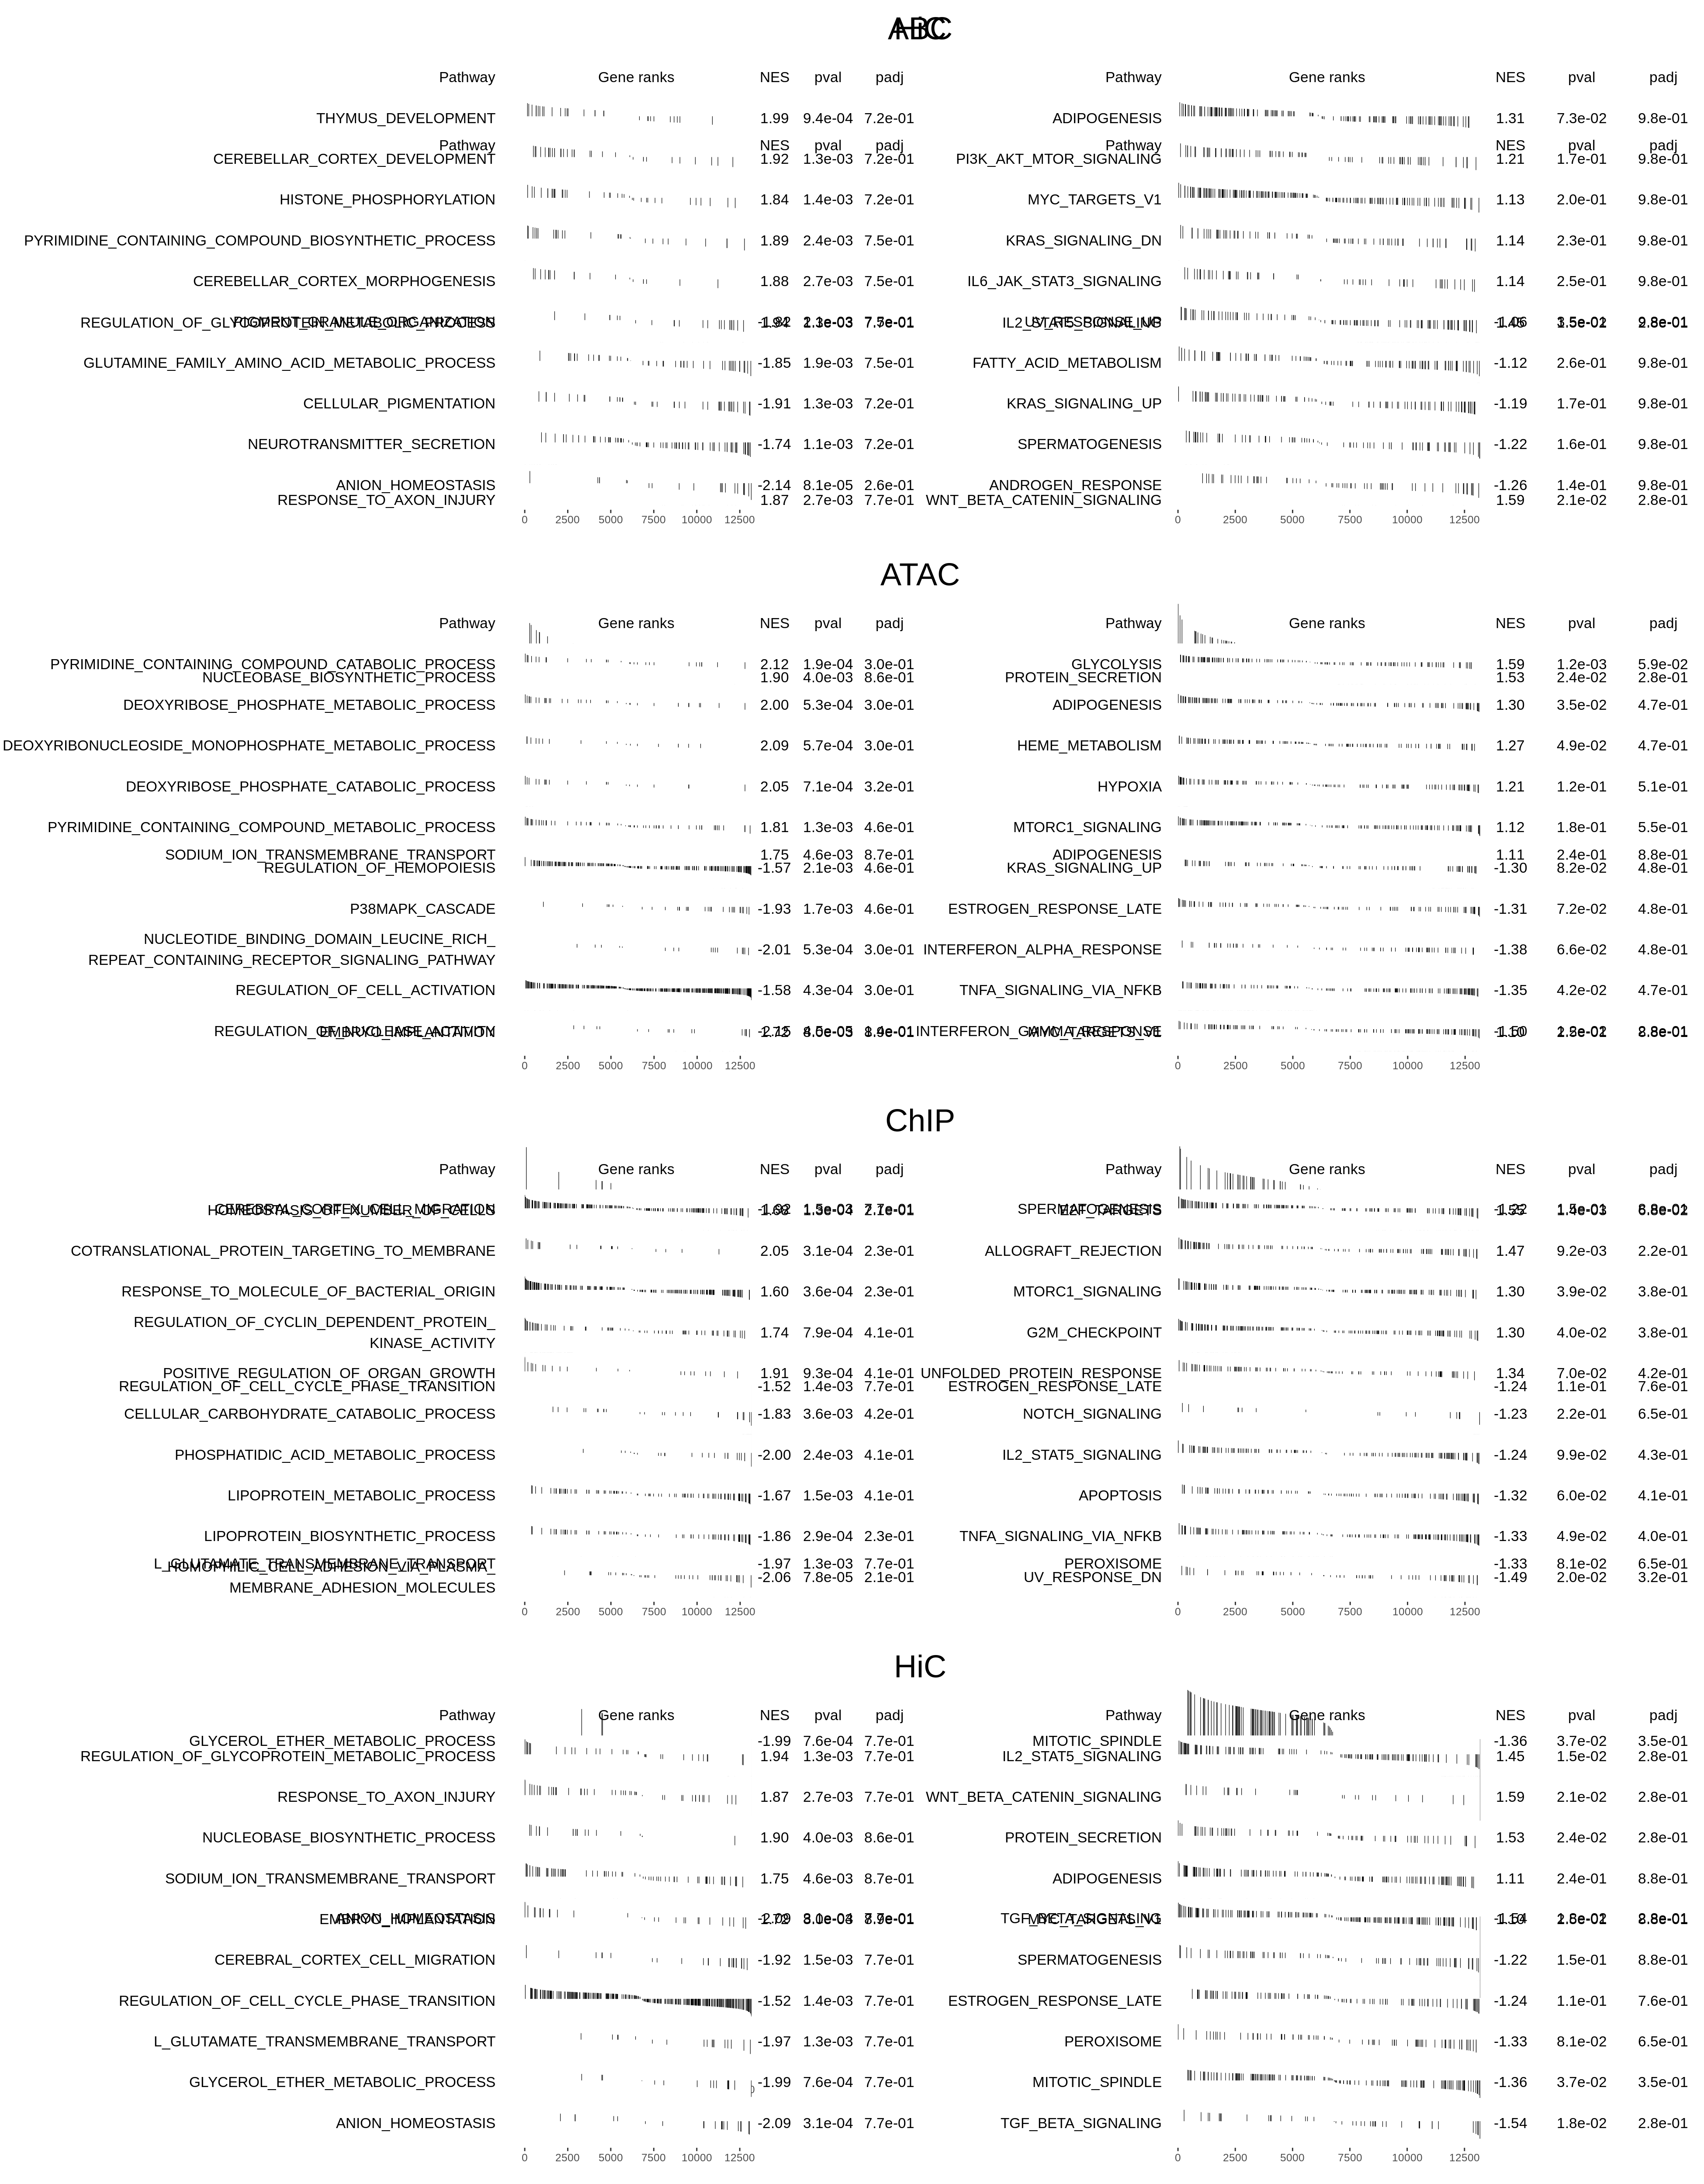

In [141]:
# run hallmark and GO:BP GSEA for each score type ranked by gsea_stat
allgenesets <- msigdbr::msigdbr("Homo sapiens")
gsea_res <- aggregate_gsea(d_all, allgenesets=allgenesets, remove_antisense=TRUE, debug=FALSE)

options(repr.plot.width = 19.5, repr.plot.height = 25, repr.plot.res = 200)
grid::grid.draw(gsea_res$plot_obj)


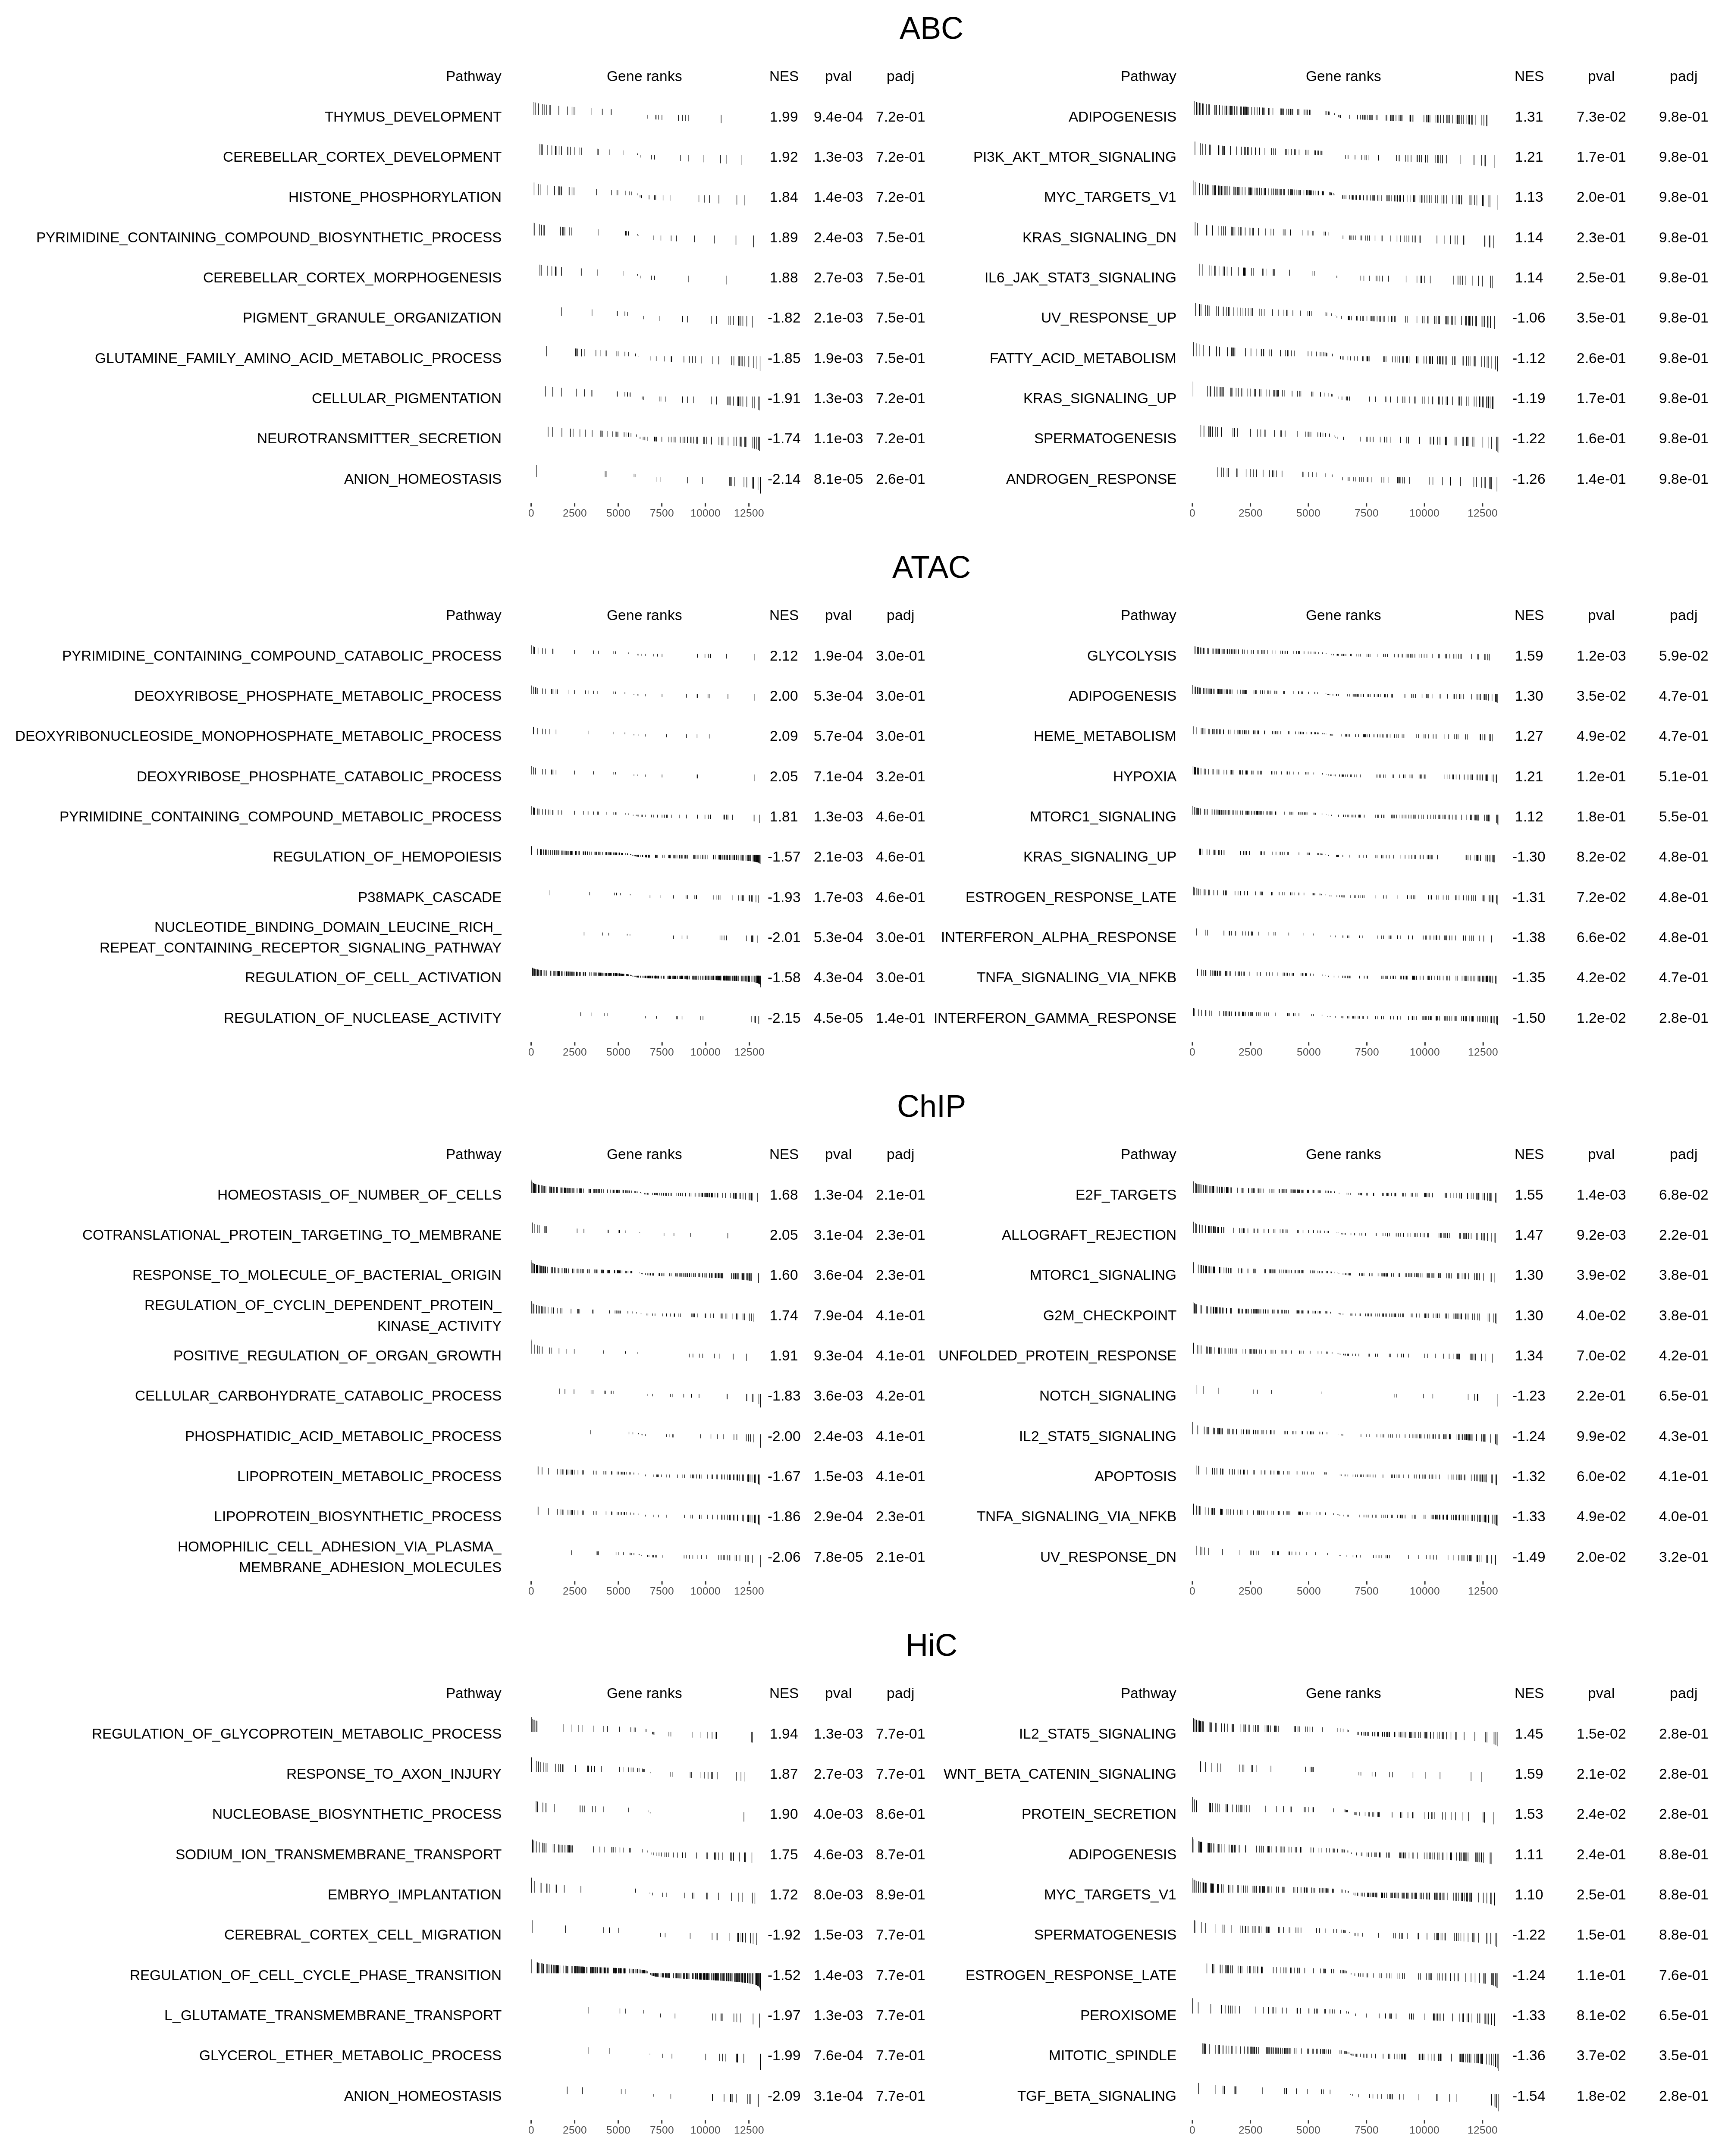

In [145]:
options(repr.plot.width = 20, repr.plot.height = 25, repr.plot.res = 200)
grid::grid.draw(gsea_res$plot_obj)

In [146]:
ggsave(file.path(outdir, 'FigS20.png'), plot=gsea_res$plot_obj, width=20, height=25)